In [1]:
import sys         
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal  #追加

In [2]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def func_state_transition(self, nu, omega, time, pose): #追加（IdealRobotからコピー）
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*nu + ns[1]*omega
        pomega = omega + ns[2]*nu + ns[3]*omega
        self.pose = self.func_state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl:  
    def __init__(self, init_pose, num, motion_noise_vars): #引数追加
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_vars #5,6行目追加
        self.motion_noise_rate_pdf = multivariate_normal(cov=np.diag([v["nn"], v["no"], v["on"], v["oo"]]))
        
    def motion_update(self, nu, omega, time): #追加
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100, #time_interval追加
                            motion_noise_vars={"nn":1.0, "no":1.0, "on":1.0, "oo":1.0}):  #追加
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_vars) #引数追加
        self.time_interval = time_interval #追加
        
    def decision(self):                     #追加
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

In [5]:
initial_pose = np.array([2, 2, math.pi/6]).T
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)
a.decision()

(0.2, 0.17453292519943295)

<IPython.core.display.Javascript object>


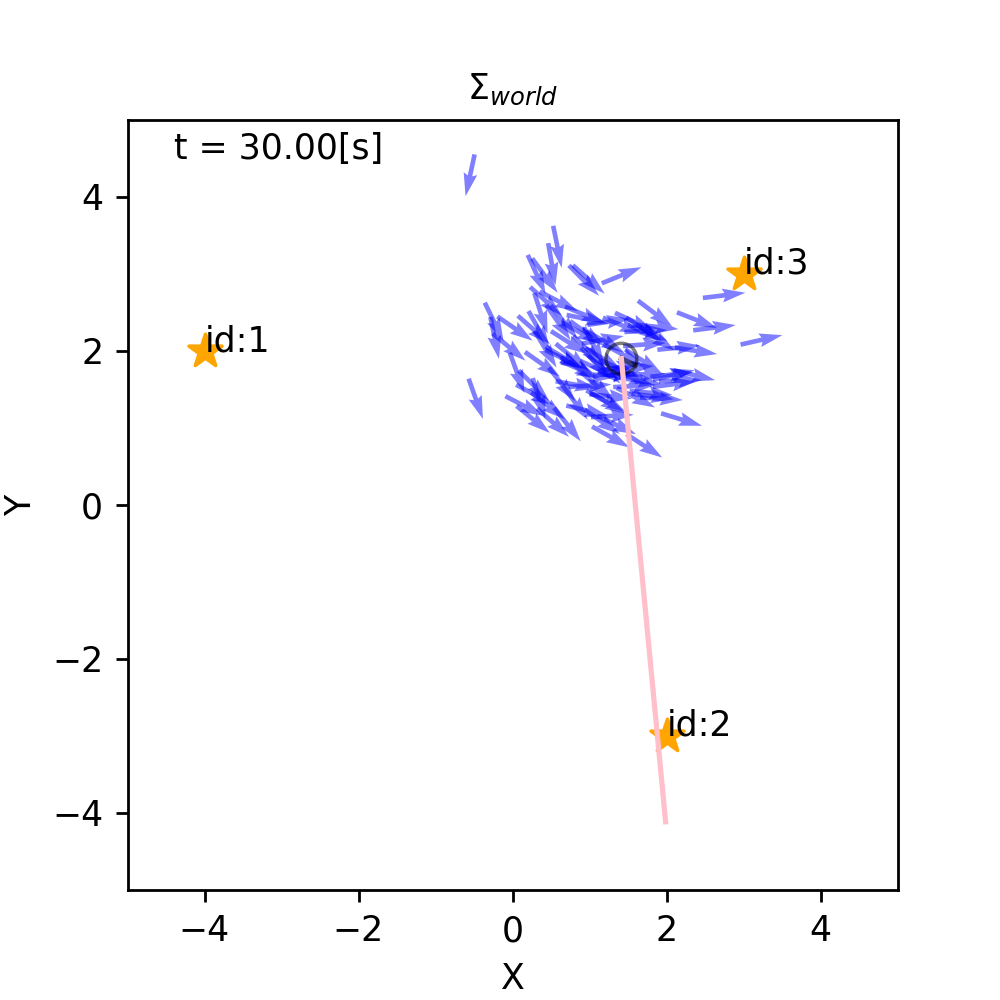

In [6]:
world = World(30, 0.1)  

### 地図を生成して3つランドマークを追加 ###
m = Map()                                  
m.append_landmark(Landmark(-4,2))
m.append_landmark(Landmark(2,-3))
m.append_landmark(Landmark(3,3))
world.append(m)          

### ロボットを作る ###
initial_pose = np.array([2, 2, math.pi/6]).T
circling = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)  #initial_poseを追加  
r = Robot(initial_pose, sensor=Camera(m), agent=circling) 
world.append(r)

### アニメーション実行 ###
world.draw()

In [7]:
r.agent.mcl.particles[0].pose

array([ 2.        ,  2.        ,  0.52359878])